# Density normalization: 1st step: ground-truth

The X-ray CT scans can be stacked to form 3D numpy arrays saved as TIFF files. In our case, we saved the scans with 8-bit resoltion, so that each voxel has a density value ranging from `0` to `255`. The X-ray CT scan measures **relative** density rather than absolute density. That is, the lowest density voxel in the object gets treated as density `0` while the densest point is treated as `255` with a linear interpolation for the rest of voxels. This means that two different sets of barley spikes could report vastly different densities!

We assume that every barley spike has essentially the same density, and that relative differences are caused by specks of metal or other material. Before going into any image processing and cleanup, we must normalize the densities, that is, make sure that barley spikes report the same density across all scans.

The strategy is to take the densities reported in scan `S010.tif` as our ground truth, and then adjust the rest of scans to fit such ground truth. The selection of `S010.tif` was arbitrary.

In [1]:
import tifffile as tf
import numpy as np
import os
from matplotlib import pyplot as plt
import math
import importlib
import demeter.unionfind as UF

In [2]:
dst = '../../preproc/raw/'
filepath  = '../../preproc/raw/S010.tif'

## Load the raw scan to normalize

Load the scan to normalize and compute its density histogram with 256 bins, as voxels can take up to 256 different density values.

- The number of bins is actually deduced from the TIFF file itself

In [3]:
_ , fname = os.path.split(filepath)
bname = os.path.splitext(fname)[0]
img = tf.imread(filepath)

hist0,bins = np.histogram(img,bins=2**(img.dtype.itemsize*8),range=(0,2**(img.dtype.itemsize*8)))
tot = img.size
cumul = np.cumsum(hist0)

## Do 0-dim persistence to find the three most prominent peaks

We compute 0-dimensional persistence (that is, keep track of growing, separate connected components) using a Union-Find data structure, also known as disjoint-set data structure. 

The data structure mantains a collection $S=\{S_i\}_i$ of disjoint sets where each of them has an element that works as the representative. 

In our case, 

1. We start by sorting all the density values ($\rho=0,1,\ldots,255$) based on number of voxels. That is, the most common density value goes first.
1. Make a set with only one element: the most common density value $\rho_1$
1. Insert a second set with only one element: the second most common density value $\rho_2$
1. If $|\rho_1-\rho_2|=1$, then both sets are merged.
1. Repeat the same procedure for the rest of $\rho_3,\ldots,\rho_{256}$.

<p><a href="https://commons.wikimedia.org/wiki/File:Dsu_disjoint_sets_init.svg#/media/File:Dsu_disjoint_sets_init.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Dsu_disjoint_sets_init.svg/1200px-Dsu_disjoint_sets_init.svg.png" alt="Dsu disjoint sets init.svg" width=400></a></p>

<p><a href="https://commons.wikimedia.org/wiki/File:Dsu_disjoint_sets_final.svg#/media/File:Dsu_disjoint_sets_final.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ac/Dsu_disjoint_sets_final.svg/1200px-Dsu_disjoint_sets_final.svg.png" alt="Dsu disjoint sets final.svg" width=400></a></p>

We keep track of the persistence (how many iterations did it last) of all connected components. 

- We keep special attention to the critical density values that merge two different, persistent connected components. 

Look at the `unionfind.py` file for more details.

For scan `S010.tif`: 
- We see that the most persistent density value is $45$
- The second most persistent component was first introduced (birth) at $21$ and was merged (death) at $23$. 
    - The difference of number of voxels (persistence) of density $21$ versus $23$ was of 1,834,474

In [5]:
importlib.reload(UF)
pers = sorted(UF.persistence(hist0),reverse=True)
pers

[(inf, None, 45),
 (1834474, 23, 21),
 (517220, 167, 225),
 (333, 165, 166),
 (219, 159, 160),
 (166, 176, 175),
 (59, 152, 153),
 (57, 173, 171),
 (2, 1, 0),
 (1, 253, 255),
 (1, 249, 250),
 (1, 11, 10),
 (1, 6, 5),
 (1, 3, 2)]

Alternatively, we could sort them by how large was the persistence of the connected component relative to number of voxels.
- Here 45 remains the most persistent density value
- The second most persistent component was first introduced (birth) at $225$ and was merged (death) at $167$. 
    - The difference of number of voxels of density $225$ versus $167$ represents 90.9% of the total of voxels with density $225$.

In [7]:
pers = sorted(UF.rel_persistence(hist0),reverse=True)
pers

[(inf, None, 45),
 (0.9089071920739047, 167, 225),
 (0.11859849950245463, 23, 21)]

- The three important scan peaks corresponding to density of
    - Air = 21
    - Foam = 45
    - Grain = 225
- `anchors`: Corresponding density quantiles
    - 1.02% or voxels report a density lower than 21
    - 60.3% of voxels report a density lower than 45
    - 99.9% of voxels report a density lower than 225

In [8]:
p0,p1,p2 = pers[:3]
x0,x1,x2 = p0[2],p1[2],p2[2]
anchors = [cumul[x0]/tot,cumul[x1]/tot,cumul[x2]/tot]

print(x0,x1,x2)
print(anchors)

45 225 21
[0.6038812815879672, 0.9993583612061564, 0.010151476150622665]


**Note:** We used `rel_persistence` to find the peaks, but `persistence` produces the same results except in different order whenever considering only the three most prominent peaks.

## Plot the log results

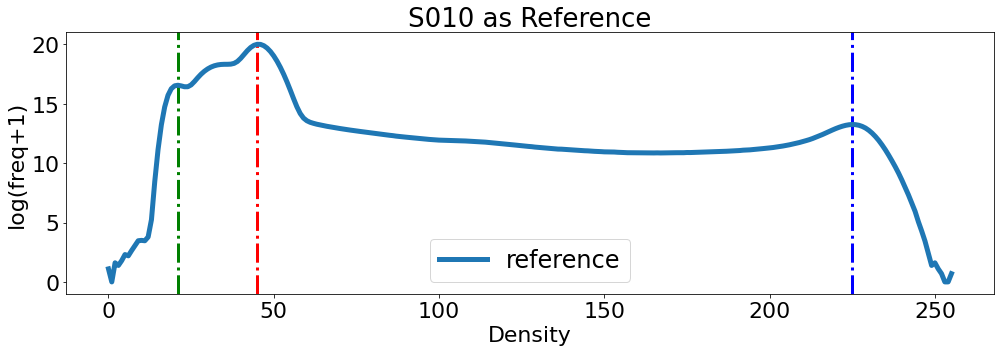

In [9]:
fig, ax = plt.subplots(figsize=(14,5))
lw = 3

ax.axvline(x0, ls='-.', lw=lw, c='r')
ax.axvline(x1, ls='-.', lw=lw, c='b')
ax.axvline(x2, ls='-.', lw=lw, c='g')

ax.plot([b for b in bins[:-1]],[np.log(h+1) for h in hist0], lw=lw+2, label = 'reference')

ax.set_xlabel("Density", fontsize=22)
ax.set_ylabel("log(freq+1)", fontsize=22)
ax.set_title(bname + ' as Reference', fontsize=26)
ax.tick_params(labelsize=22)
ax.legend(fontsize=24)
plt.tight_layout()

#plt.savefig(dst+'hists/' + bname+'_normalization++.jpg', dpi=175, format='jpg', pil_kwargs={'optimize':True})

## Save the quantiles and their location for quick use

In [26]:
np.savetxt(dst + 'normalization_yvals.csv', np.array([x0,x1,x2]), fmt='%d', delimiter = ',')
np.savetxt(dst + 'normalization_anchors.csv', anchors, fmt='%.18e', delimiter = ',')